<h1 style="text-align: center; font-weight: bold; font-size: 36px;">Character Level MLP - Activations, Gradients and BatchNorm</h1>

# Introduction

Let's create a **MLP** model. Explore training and debugging techniques.

Inspired by Karpathy [Neural Networks: Zero-to-Hero](https://github.com/karpathy/nn-zero-to-hero). 
We are using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) as in Zero to Hero so we can compare results.

# Imports

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, sci_mode=False)

# PyTorch-ify

In [247]:
class Tokenizer:
    def __init__(self, vocab):
        assert isinstance(vocab, list)
        assert all(isinstance(v, str) for v in vocab)
        assert all(len(v) == 1 for v in vocab)
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}

    def encode(self, text):
        return [self.stoi[s] for s in text]

    def decode(self, sequence):
        if isinstance(sequence, list):
            return ''.join([self.itos[i] for i in sequence])
        elif isinstance(sequence, torch.Tensor):
            assert sequence.ndim in [0, 1]
            if sequence.ndim == 0:
                return self.itos[sequence.item()]  # one char
            else:
                return ''.join([self.itos[i.item()] for i in sequence])
        else:
            raise ValueError(f"Type {type(sequence)} not supported")

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
        

class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features)) / (in_features**0.5)
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __init__(self):
        pass

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gain = torch.ones(num_features)
        self.bias = torch.zeros(num_features)
        
        self.mean_running = torch.zeros(num_features)
        self.var_running = torch.ones(num_features)

    def __call__(self, x):
        if self.training:
            x_mean = torch.mean(x, dim=0, keepdim=True)
            x_var = torch.var(x, dim=0, keepdim=True)
            with torch.no_grad():
                self.mean_running = (1-self.momentum) * self.mean_running + self.momentum * x_mean
                self.var_running = (1-self.momentum) * self.var_running + self.momentum * x_var
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        zx = (x - x_mean) / (x_var + self.eps)**0.5  # sqrt
        self.out = zx * self.gain + self.bias
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

# Build the Dataset

In [2]:
with open('../data/names.txt', 'r') as f:
    names = f.read().splitlines()
print("Num names:", len(names))
print("Example names:", names[:10])
print("Min length:", min(len(name) for name in names))
print("Max length:", max(len(name) for name in names))

Num names: 32033
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Min length: 2
Max length: 15


In [3]:
# Get vocabulary
letters = sorted(list(set(''.join(names))))
letters = ['.'] + letters
n_vocab = len(letters)
print(letters)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
def build_dataset(tok, block_size, names):
    X, Y = [], []  # inputs and targets
    for name in names:
        name = '.'*block_size + name + '.'  # add start/stop tokens '..emma.'
        for i in range(len(name) - block_size):
            X.append(tok.encode(name[i:i+block_size]))
            Y.append(tok.encode(name[i+block_size])[0])  # [0] to keep Y 1d tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
block_size = 3  # context length
tok = Tokenizer(vocab=letters)

random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(tok, block_size, names[:n1])
Xval, Yval = build_dataset(tok, block_size, names[n1:n2])
Xtest, Ytest = build_dataset(tok, block_size, names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# Expected initial loss:
expected_initial_loss = -1 * torch.tensor(1/n_vocab).log()
print(expected_initial_loss)

tensor(3.2958)


In [ ]:
# Experiments:
# - play with kaming init: 5/3
# - play with weight init in Linear: / (in_features**0.5)

# Random Init
torch.manual_seed(42)

# Hyperparameters
n_embd = 10
n_hidden = 100

# Model
embd = Embedding(n_vocab, n_embd)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,          n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,          n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,          n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,          n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,          n_vocab),  BatchNorm1d(n_vocab),
]

# Adjust Slightly
with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3  # Kaiming init
    layers[-1].gain *= 0.1     # <-- last layer is now batchnorm, adjust gain

# END OF OPTIONS

# Gather Params
params = [*embd.parameters()] + [p for l in layers for p in l.parameters()]

# Enable Grad
for p in params:
    p.requires_grad = True

# Total Num Params
print(sum(p.nelement() for p in params))

47551


In [249]:
iters, losses, ud = [], [], []

lr_schedule = [0.1]*100000 + [0.01]*100000
num_epochs = len(lr_schedule)
batch_size = 32
i = 0

In [250]:
for _ in range(num_epochs):

    # Model Setup
    pass  # enable batch train norm here

    # Mini Batch
    batch_indices = torch.randint(0, Xtr.shape[0], (batch_size,))
    x_batch = Xtr[batch_indices]
    y_batch = Ytr[batch_indices]

    # Forward
    x = embd(x_batch)                    # n_batch, n_seq, n_emb
    x = x.view(-1, n_embd*block_size)    # n_batch, n_embd*block_size
    for l in layers:
        x = l(x)

    # Loss
    loss = F.cross_entropy(x, y_batch)

    # Backward
    for l in layers:
        l.out.retain_grad()    # debug/experiments
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lr_schedule[i]
    for p in params:
        p.data += -lr * p.grad

    # Stats
    if i % 10000 == 0:
        print(i, loss.item())
    iters.append(i)
    losses.append(loss.item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in params])
    i += 1

    # Break
    if i >= 1000:
        break

print(i, loss.item())

0 3.2998499870300293
1000 2.3435845375061035


i=2 (    Tanh) mean=-0.0086 std=0.6353 sat=2.1875
i=5 (    Tanh) mean=0.0033 std=0.6437 sat=2.0312
i=8 (    Tanh) mean=0.0009 std=0.6457 sat=2.0938
i=11 (    Tanh) mean=-0.0046 std=0.6485 sat=1.9688
i=14 (    Tanh) mean=0.0093 std=0.6469 sat=1.9375


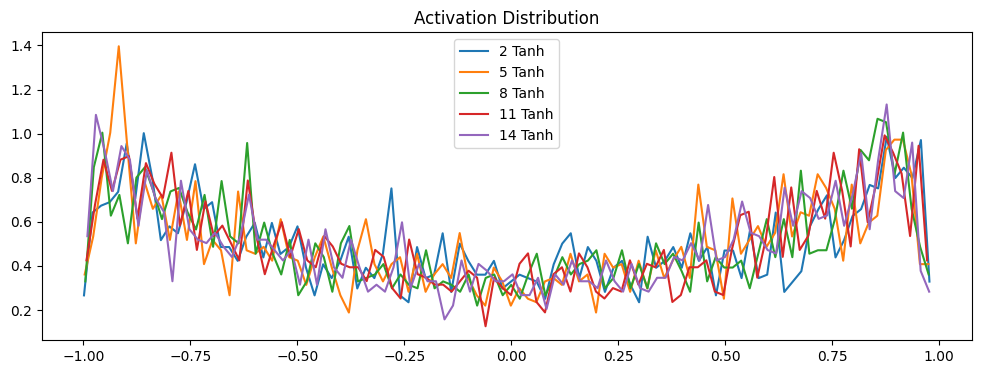

In [251]:
# Activation Distribution
with torch.no_grad():
    plt.figure(figsize=(12,4))
    legends = []
    for i, l in enumerate(layers[:-1]):  # exclude output layer
        if isinstance(l, Tanh):
            hy, hx = torch.histogram(l.out, density=True)
            plt.plot(hx[:-1], hy)
            legends.append(f"{i} {l.__class__.__name__}")
            t_sat = (l.out.abs() > 0.97).float().mean()*100
            print(f"{i=} ({l.__class__.__name__:>8}) mean={l.out.mean().item():.4f} "
                  f"std={l.out.std().item():.4f} sat={t_sat.item():.4f}")
    plt.legend(legends)
    plt.title("Activation Distribution")
    plt.show()

i=2 (    Tanh) mean=-0.000000 std=0.003533
i=5 (    Tanh) mean=0.000000 std=0.002951
i=8 (    Tanh) mean=0.000000 std=0.002730
i=11 (    Tanh) mean=0.000000 std=0.002545
i=14 (    Tanh) mean=-0.000000 std=0.002519


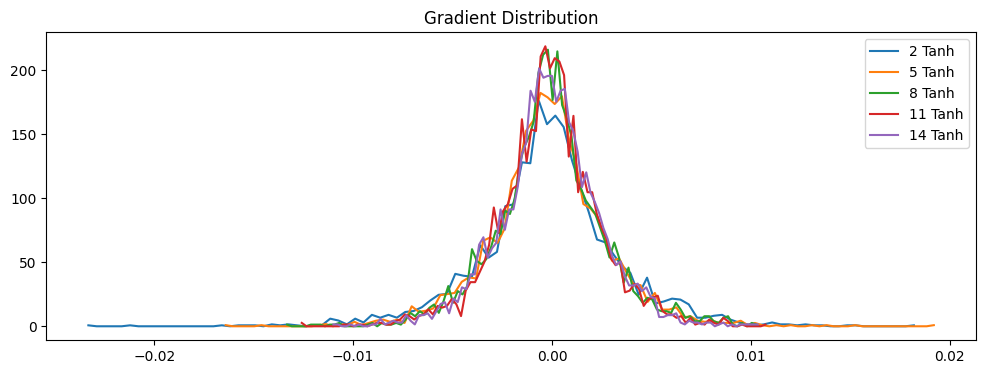

In [252]:
# Gradient Distribution
with torch.no_grad():
    plt.figure(figsize=(12,4))
    legends = []
    for i, l in enumerate(layers[:-1]):  # exclude output layer
        if isinstance(l, Tanh):
            hy, hx = torch.histogram(l.out.grad, density=True)
            plt.plot(hx[:-1], hy)
            legends.append(f"{i} {l.__class__.__name__}")
            print(f"{i=} ({l.__class__.__name__:>8}) mean={l.out.grad.mean().item():.6f} "
                  f"std={l.out.grad.std().item():.6f}")
    plt.legend(legends)
    plt.title("Gradient Distribution")
    plt.show()

i= 0 (  (27, 10)) mean= 0.000000 std= 0.008357 g/d= 0.008348
i= 1 ( (30, 100)) mean= 0.000031 std= 0.007933 g/d= 0.026033
i= 5 ((100, 100)) mean= 0.000012 std= 0.006578 g/d= 0.039488
i= 9 ((100, 100)) mean= 0.000009 std= 0.005528 g/d= 0.033009
i=13 ((100, 100)) mean= 0.000003 std= 0.004933 g/d= 0.029618
i=17 ((100, 100)) mean=-0.000007 std= 0.004945 g/d= 0.029119
i=21 ( (100, 27)) mean=-0.000190 std= 0.011323 g/d= 0.067436


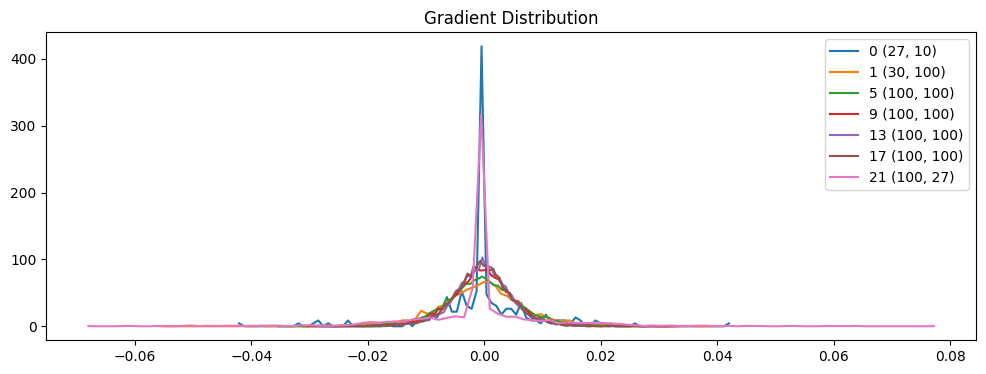

In [253]:
# Weight Gradient Distribution
# NOTE: The 1e-3 rule of thumb:
# We want slow and steady weight upddates
# lr * grad = 0.1 * (1e-3*wegith) = ~0.1% per step
with torch.no_grad():
    plt.figure(figsize=(12,4))
    legends = []
    for i, p in enumerate(params):
        if p.ndim == 2:
            hy, hx = torch.histogram(p.grad, density=True)
            plt.plot(hx[:-1], hy)
            legends.append(f"{i} {tuple(p.shape)}")
            print(f"{i=:>2} ({str(tuple(p.shape)):>10}) "
                  f"mean={p.grad.mean().item(): .6f} "
                  f"std={p.grad.std().item(): .6f} "
                  f"g/d={p.grad.std().item()/p.std().item(): .6f}"
                )
    plt.legend(legends)
    plt.title("Gradient Distribution")
    plt.show()

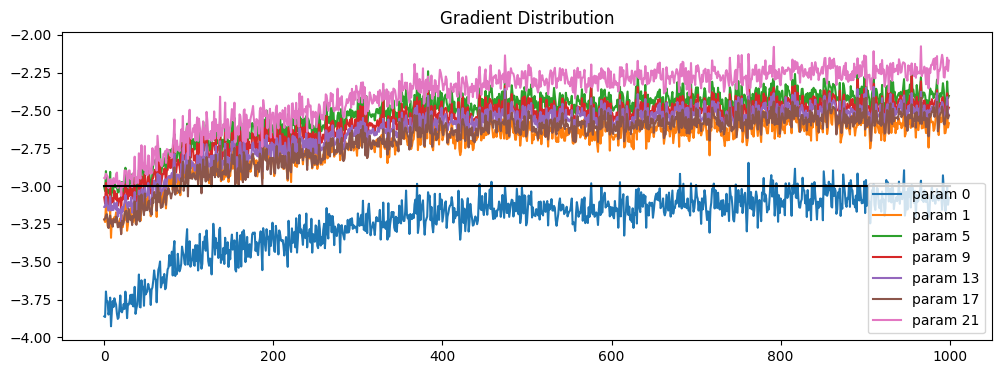

In [254]:
# Update/Data over time
with torch.no_grad():
    plt.figure(figsize=(12,4))
    legends = []
    for i, p in enumerate(params):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append(f"param {i}")
    plt.plot([0, len(ud)], [-3, -3], "k")  # rations should be ~1e-3
    plt.legend(legends)
    plt.title("Gradient Distribution")
    plt.show()